Stored in basuarkaprabha0@gmail.com

In [3]:
import numpy as np
import os
import zipfile
import pandas as pd
import random
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.4.1


In [8]:
#Connect Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
#Take input the pretrianed model stored in basuarkaprabha1012
from keras.models import load_model
model=load_model("/content/gdrive/MyDrive/TrueTOTAL200dataResnset.h5")

In [10]:
class GradCAM:
    # Adapted with some modification from https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/
    def __init__(self, model, layerName=None):
        """
        model: pre-softmax layer (logit layer)
        """
        self.model = model
        self.layerName = layerName
            
        if self.layerName == None:
            self.layerName = self.find_target_layer()
    
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM")
            
    def compute_heatmap(self, image, classIdx, upsample_size, eps=1e-5):
        gradModel = Model(
            inputs = [self.model.inputs],
            outputs = [self.model.get_layer(self.layerName).output, self.model.output]
        )
        # record operations for automatic differentiation
        
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOuts, preds) = gradModel(inputs) # preds after softmax
            loss = preds[:,classIdx]
        
        # compute gradients with automatic differentiation
        grads = tape.gradient(loss, convOuts)
        # discard batch
        convOuts = convOuts[0]
        grads = grads[0]
        norm_grads = tf.divide(grads, tf.reduce_mean(tf.square(grads)) + tf.constant(eps))
        
        # compute weights
        weights = tf.reduce_mean(norm_grads, axis=(0,1))
        cam = tf.reduce_sum(tf.multiply(weights, convOuts), axis=-1)
        
        # Apply reLU
        cam = np.maximum(cam, 0)
        cam = cam/np.max(cam)
        cam = cv2.resize(cam, upsample_size,interpolation=cv2.INTER_LINEAR)
        
        # convert to 3D
        cam3 = np.expand_dims(cam, axis=2)
        cam3 = np.tile(cam3, [1,1,3])
        
        return cam3
    
def overlay_gradCAM(img, cam3):
    cam3 = np.uint8(255*cam3)
    cam3 = cv2.applyColorMap(cam3, cv2.COLORMAP_JET)
    
    new_img = 0.3*cam3 + 0.5*img
    
    return (new_img*255.0/new_img.max()).astype("uint8")

In [11]:
@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad

# Reference: https://github.com/eclique/keras-gradcam with adaption to tensorflow 2.0  
class GuidedBackprop:
    def __init__(self,model, layerName=None):
        self.model = model
        self.layerName = layerName
        self.gbModel = self.build_guided_model()
        
        if self.layerName == None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply Guided Backpropagation")

    def build_guided_model(self):
        gbModel = Model(
            inputs = [self.model.inputs],
            outputs = [self.model.get_layer(self.layerName).output]
        )
        layer_dict = [layer for layer in gbModel.layers[1:] if hasattr(layer,"activation")]
        for layer in layer_dict:
            if layer.activation == tf.keras.activations.relu:
                layer.activation = guidedRelu
        
        return gbModel
    
    def guided_backprop(self, images, upsample_size):
        """Guided Backpropagation method for visualizing input saliency."""
        with tf.GradientTape() as tape:
            inputs = tf.cast(images, tf.float32)
            tape.watch(inputs)
            outputs = self.gbModel(inputs)

        grads = tape.gradient(outputs, inputs)[0]

        saliency = cv2.resize(np.asarray(grads), upsample_size)

        return saliency

def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [23]:
def show_gradCAMs(model, gradCAM, GuidedBP, im_ls, n=1, decode={}):
    """
    model: softmax layer
    """
    #random.shuffle(im_ls)
    plt.subplots(figsize=(20, 5*n))
    k=1
    for i in range(1):
        img = cv2.imread(im_ls)
        
        upsample_size = (img.shape[1],img.shape[0])
        if (i+1) == 2:
            break
        # Show original image
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        # Show overlayed grad
        im = img_to_array(load_img(im_ls))
        x = np.expand_dims(im, axis=0)
        #x = preprocess_input(x)
        preds = model.predict(x)
        i=np.argmax(preds[0])
        print(i)
        print(preds)
        #idx = preds.argmax()
        if len(preds.shape)!=2:
          raise ValueError("not done")
        results=[]
        for pred in preds:
          top_indices=pred.argsort()[-1:][::-1]
          res=pred[i]
          print(pred[i])
          results.append(res)
          decision=results
          results=results[0]*100
          print(decision)
        cam3 = gradCAM.compute_heatmap(image=x, classIdx=i, upsample_size=upsample_size)
        new_img = overlay_gradCAM(img, cam3)
        new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
        plt.imshow(new_img)
        plt.title("GRAD-CAM")
        plt.show()
        # Show guided GradCAM
        plt.subplots(figsize=(20, 5*n))
        gb = GuidedBP.guided_backprop(x, upsample_size)
        guided_gradcam = deprocess_image(gb*cam3)
        print(guided_gradcam.shape)
        plt.imshow(guided_gradcam)
        if guided_gradcam.shape[1]==1:
          guided_gradcam = cv2.cvtColor(guided_gradcam, cv2.COLOR_BGR2RGB)
        plt.imshow(guided_gradcam)       
        plt.title("GUIDED GRAD-CAM")
        k += 3
    plt.show()

In [36]:
gradCAM = GradCAM(model, layerName="conv5_block3_out")
guidedBP = GuidedBackprop(model,layerName="conv5_block3_out")
'''
if i==0:
  decision="Covid"
elif i==1:
  decision="Lung Opacity"
elif i==2:
  decision="Normal"
else:
  decision="Pneumonia"
'''

'\nif i==0:\n  decision="Covid"\nelif i==1:\n  decision="Lung Opacity"\nelif i==2:\n  decision="Normal"\nelse:\n  decision="Pneumonia"\n'

0
[[9.9983644e-01 1.0173912e-06 5.2143014e-09 1.6241224e-04]]
0.99983644
[0.99983644]


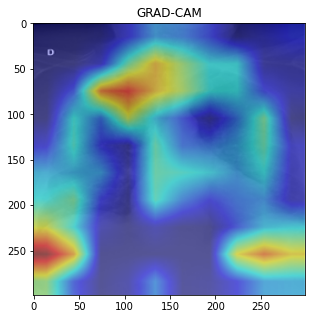

(299, 299, 3)


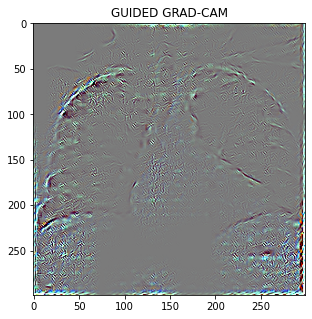

In [37]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/COVID-1923.png", n=1)

0
[[7.3004746e-01 9.0679796e-03 1.2573348e-04 2.6075882e-01]]
0.73004746
[0.73004746]


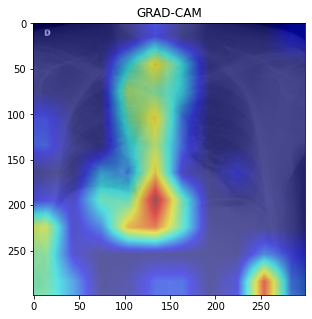

(299, 299, 3)


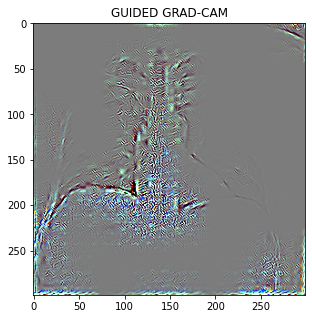

In [26]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/COVID-2283.png", n=1)

0
[[7.6581383e-01 1.9287896e-01 1.0498675e-04 4.1202217e-02]]
0.7658138
[0.7658138]


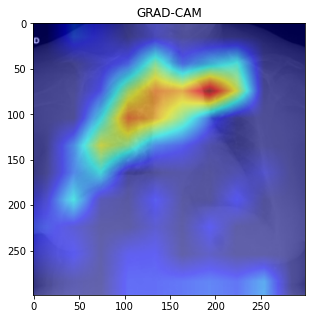

(299, 299, 3)


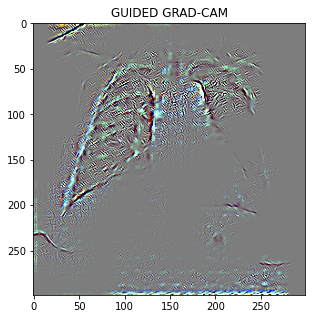

In [28]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/COVID-2137.png", n=1)

0
[[9.9999976e-01 2.7696652e-07 4.6903662e-12 8.0074567e-12]]
0.99999976
[0.99999976]


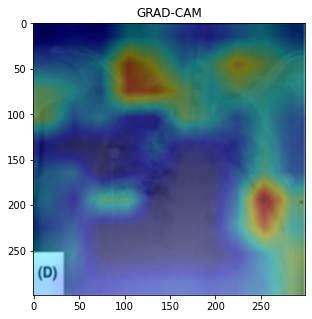

(299, 299, 3)


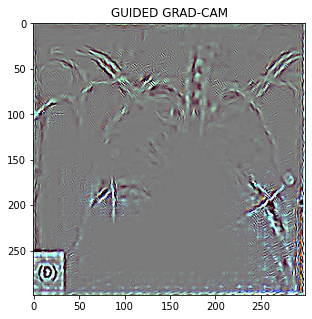

In [29]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/COVID-446.png", n=1)

0
[[9.9999261e-01 7.3341703e-06 1.1722596e-09 2.6341867e-08]]
0.9999926
[0.9999926]


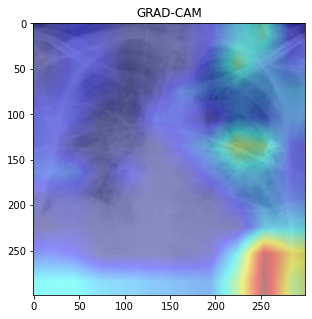

(299, 299, 3)


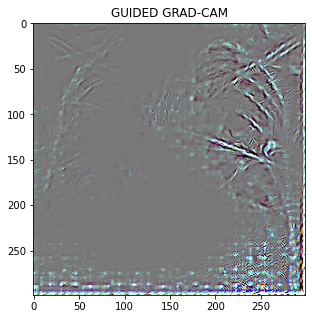

In [30]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/COVID-794.png", n=1)

0
[[9.6445227e-01 2.3088517e-02 1.2457750e-02 1.4719398e-06]]
0.96445227
[0.96445227]


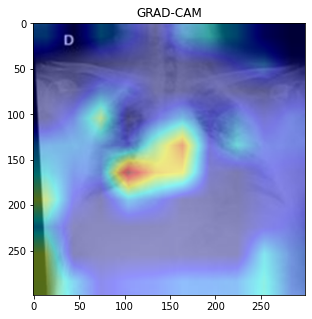

(299, 299, 3)


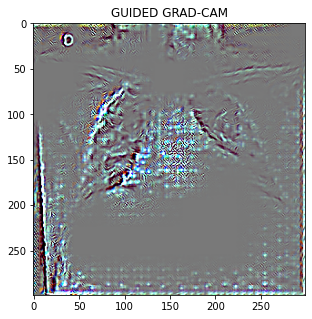

In [31]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/COVID-875.png", n=1)

0
[[9.9991739e-01 8.1749989e-05 8.0068395e-07 3.2137501e-10]]
0.9999174
[0.9999174]


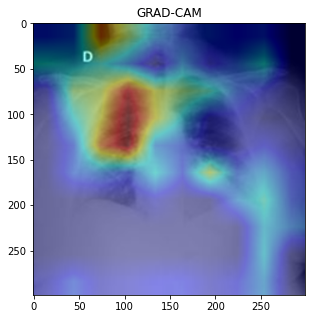

(299, 299, 3)


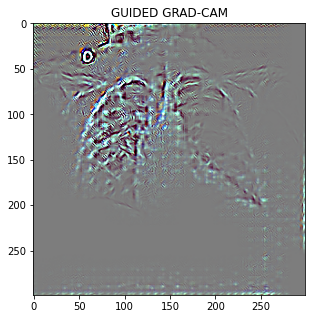

In [32]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/COVID-901.png", n=1)

0
[[1.0000000e+00 3.1284003e-08 2.5086186e-09 7.9970759e-09]]
1.0
[1.0]


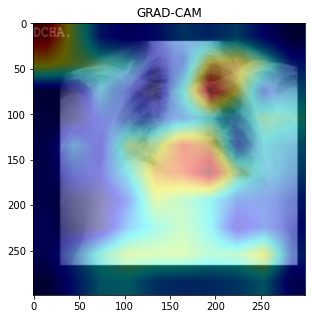

(299, 299, 3)


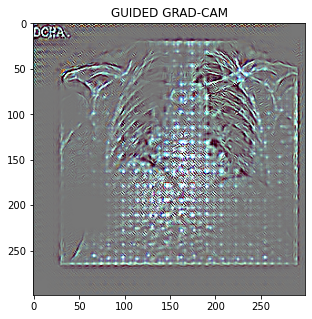

In [33]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/COVID-308.png", n=1)

0
[[9.89468157e-01 2.23849784e-04 1.15117284e-04 1.01928366e-02]]
0.98946816
[0.98946816]


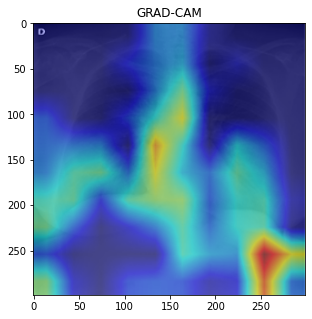

(299, 299, 3)


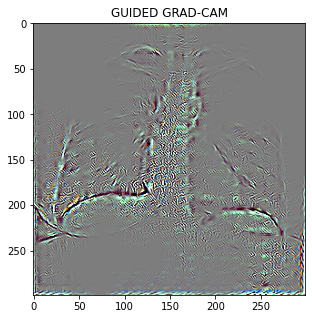

In [34]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/COVID-1086.png", n=1)

1
[[0.0034109  0.92835575 0.06445303 0.00378025]]
0.92835575
[0.92835575]


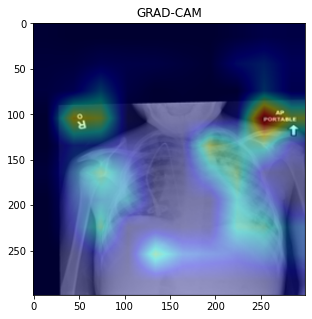

(299, 299, 3)


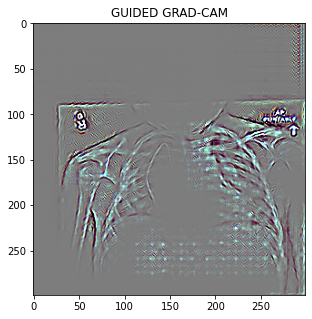

In [35]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/Lung_Opacity-5437.png", n=1)

1
[[1.0924941e-01 8.5159147e-01 3.8363211e-02 7.9586828e-04]]
0.85159147
[0.85159147]


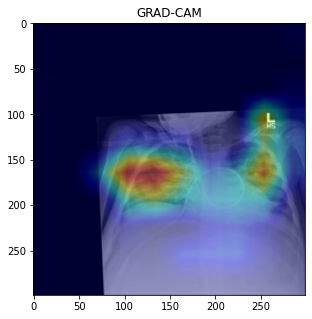

(299, 299, 3)


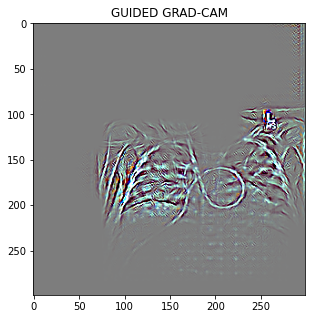

In [39]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/Lung_Opacity-812.png", n=1)

1
[[1.6295946e-04 9.9983561e-01 5.2938299e-07 8.7128973e-07]]
0.9998356
[0.9998356]


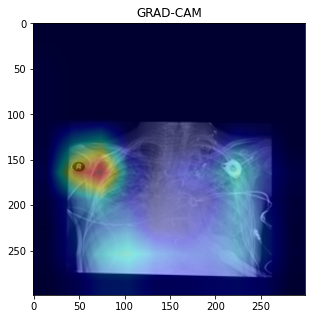

(299, 299, 3)


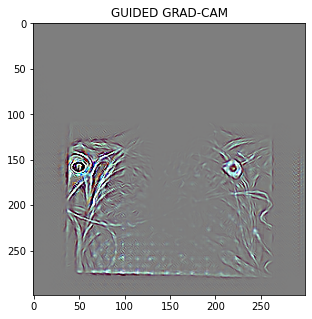

In [41]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/Lung_Opacity-3510.png", n=1)

1
[[1.80855349e-01 8.04713249e-01 1.42428195e-02 1.88582009e-04]]
0.80471325
[0.80471325]


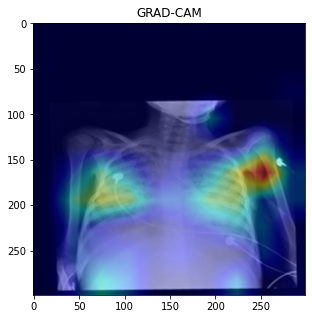

(299, 299, 3)


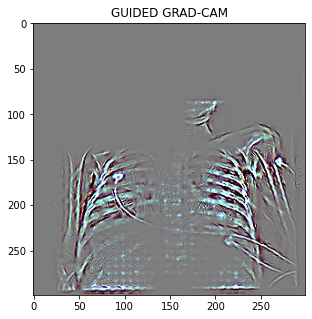

In [42]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/Lung_Opacity-5858.png", n=1)

1
[[1.7103557e-04 9.5402497e-01 4.5462791e-02 3.4114576e-04]]
0.954025
[0.954025]


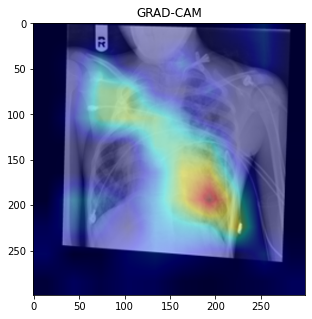

(299, 299, 3)


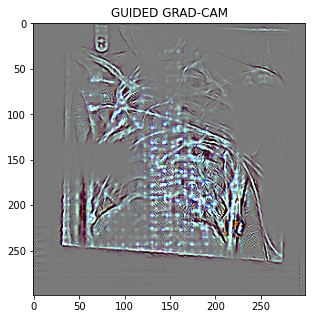

In [43]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/Lung_Opacity-3127.png", n=1)

1
[[7.2802966e-03 9.9228317e-01 2.8011124e-04 1.5652456e-04]]
0.99228317
[0.99228317]


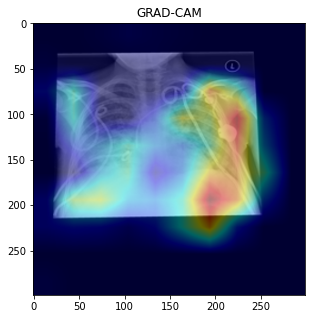

(299, 299, 3)


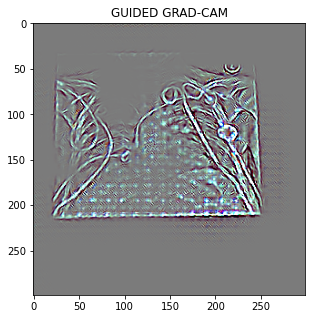

In [44]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/Lung_Opacity-28.png", n=1)

2
[[3.1484586e-05 1.1513525e-02 9.8800951e-01 4.4543587e-04]]
0.9880095
[0.9880095]


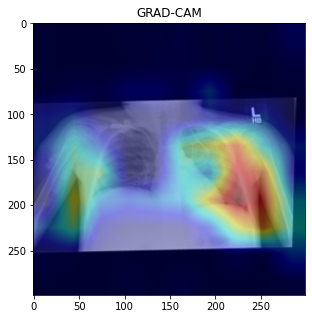

(299, 299, 3)


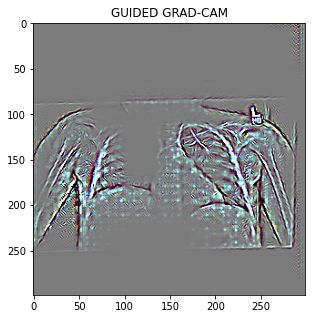

In [46]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/Normal-6374.png", n=1)

2
[[0.00364011 0.02974237 0.9652097  0.00140774]]
0.9652097
[0.9652097]


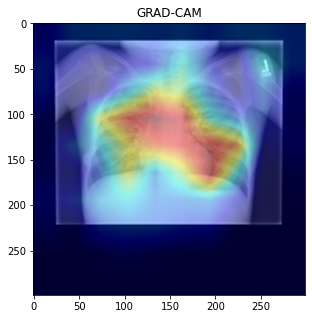

(299, 299, 3)


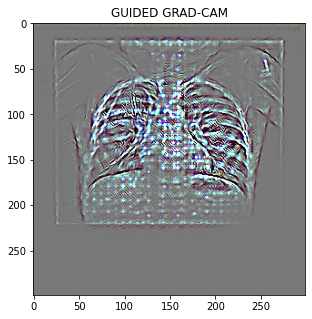

In [47]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/Normal-7861.png", n=1)

2
[[1.7903022e-01 1.5584081e-01 6.6512740e-01 1.4741682e-06]]
0.6651274
[0.6651274]


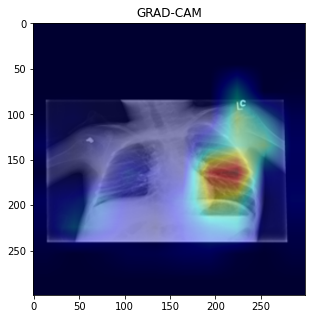

(299, 299, 3)


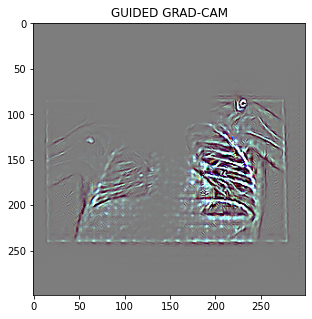

In [49]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/Normal-6485.png", n=1)

2
[[1.5989676e-04 3.6109786e-02 9.6364981e-01 8.0518781e-05]]
0.9636498
[0.9636498]


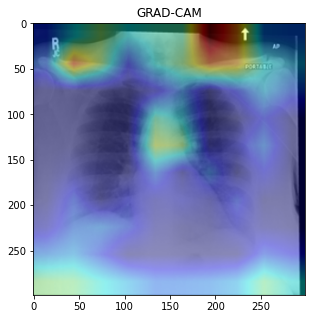

(299, 299, 3)


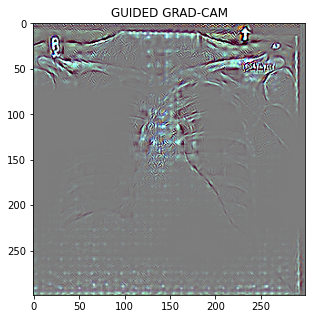

In [52]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/Normal-4362.png", n=1)

2
[[7.2893891e-03 9.6288785e-02 8.9609092e-01 3.3092735e-04]]
0.8960909
[0.8960909]


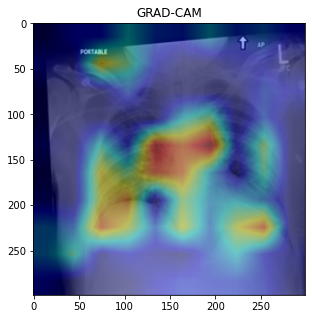

(299, 299, 3)


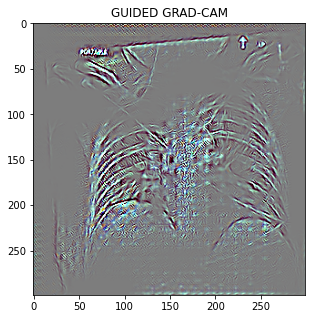

In [53]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/Normal-8091.png", n=1)

2
[[2.5330272e-03 2.0796841e-01 7.8936982e-01 1.2869411e-04]]
0.7893698
[0.7893698]


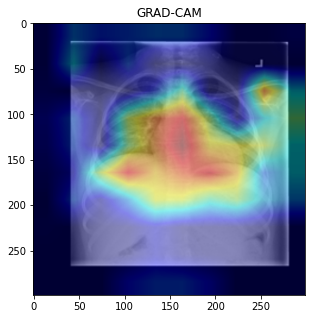

(299, 299, 3)


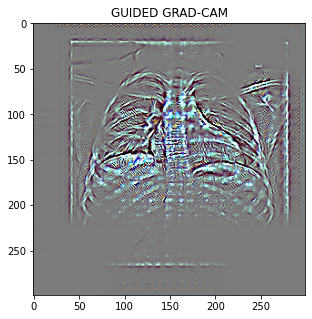

In [54]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/Normal-2003.png", n=1)

2
[[4.0381125e-04 8.6149745e-02 9.1342896e-01 1.7584574e-05]]
0.91342896
[0.91342896]


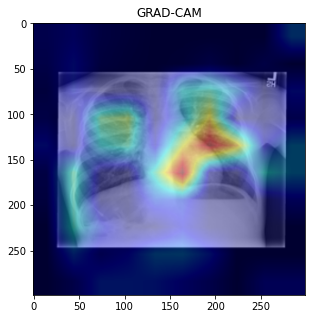

(299, 299, 3)


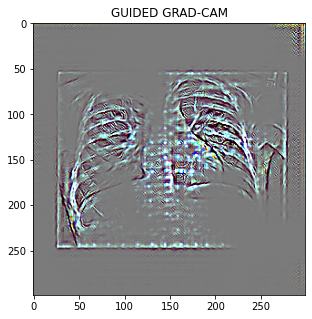

In [55]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/Normal-10040.png", n=1)

3
[[0.00078908 0.01380702 0.201816   0.78358793]]
0.78358793
[0.78358793]


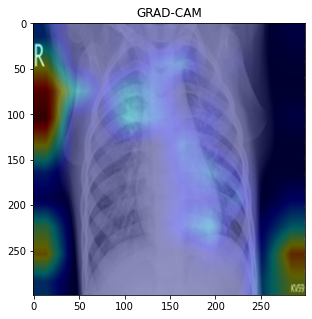

(299, 299, 3)


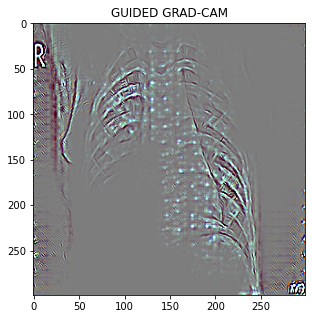

In [56]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/Viral Pneumonia-754.png", n=1)

3
[[3.33399134e-04 2.08923081e-03 1.37987565e-02 9.83778536e-01]]
0.98377854
[0.98377854]


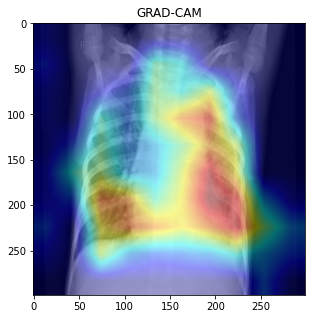

(299, 299, 3)


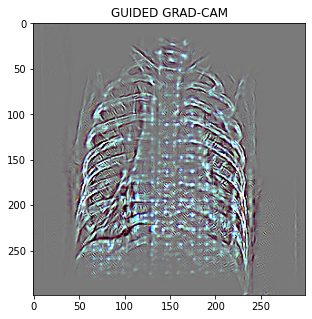

In [57]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/Viral Pneumonia-369.png", n=1)

3
[[7.7091577e-04 3.5221234e-02 2.4259517e-02 9.3974835e-01]]
0.93974835
[0.93974835]


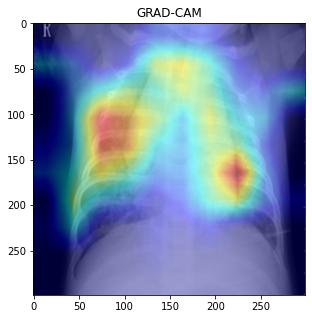

(299, 299, 3)


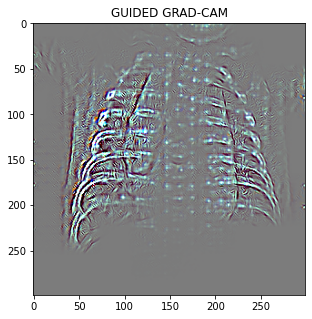

In [58]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/Viral Pneumonia-194.png", n=1)

3
[[0.00255761 0.00658021 0.00465873 0.98620343]]
0.98620343
[0.98620343]


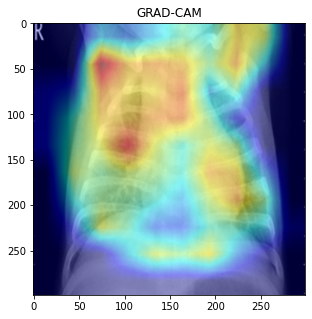

(299, 299, 3)


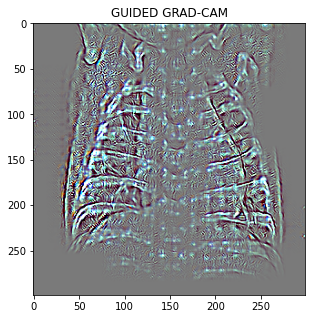

In [59]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/Viral Pneumonia-1198.png", n=1)

3
[[0.00422042 0.00504248 0.00600346 0.98473376]]
0.98473376
[0.98473376]


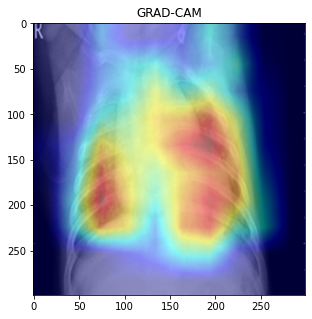

(299, 299, 3)


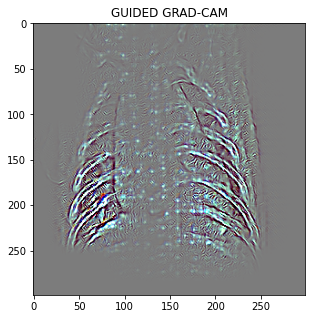

In [60]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/Viral Pneumonia-1174.png", n=1)

3
[[0.02860131 0.06322677 0.03874358 0.86942834]]
0.86942834
[0.86942834]


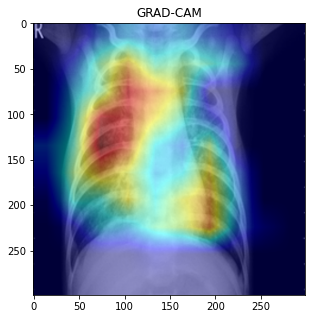

(299, 299, 3)


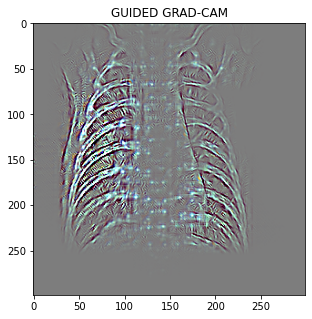

In [62]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/Viral Pneumonia-896.png", n=1)

3
[[0.01237681 0.04520032 0.00187458 0.94054824]]
0.94054824
[0.94054824]


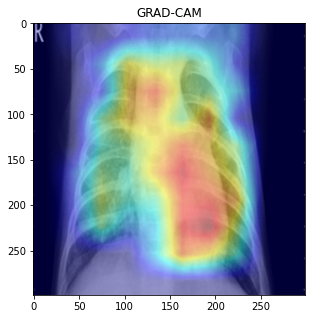

(299, 299, 3)


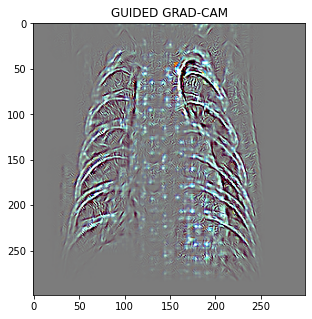

In [63]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/Viral Pneumonia-714.png", n=1)

3
[[0.09628863 0.3429008  0.18018289 0.3806277 ]]
0.3806277
[0.3806277]


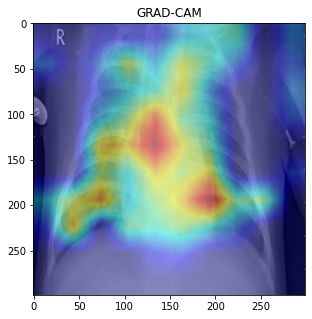

(299, 299, 3)


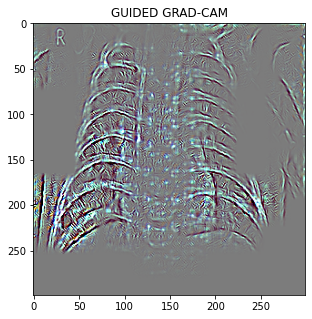

In [64]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/Viral Pneumonia-665.png", n=1)

3
[[0.17567185 0.04449851 0.01177655 0.7680531 ]]
0.7680531
[0.7680531]


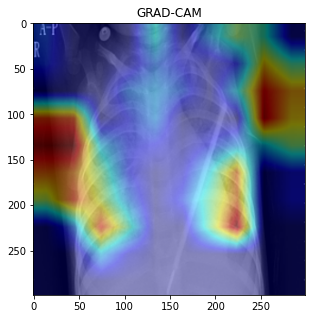

(299, 299, 3)


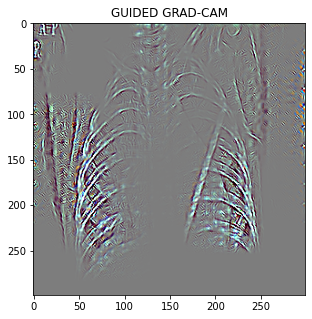

In [65]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/Viral Pneumonia-255.png", n=1)

3
[[0.00598307 0.00139269 0.03443259 0.9581917 ]]
0.9581917
[0.9581917]


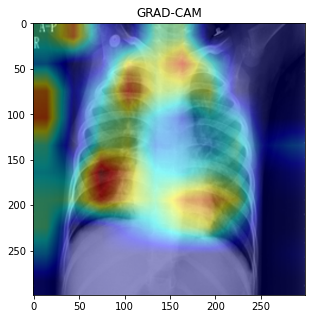

(299, 299, 3)


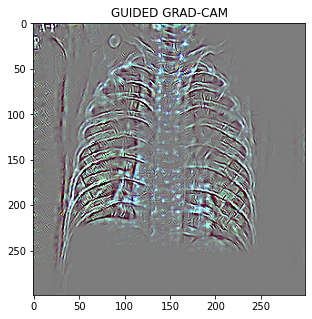

In [66]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/Viral Pneumonia-95.png", n=1)

3
[[2.1036629e-05 5.2518591e-02 1.1243825e-01 8.3502203e-01]]
0.83502203
[0.83502203]


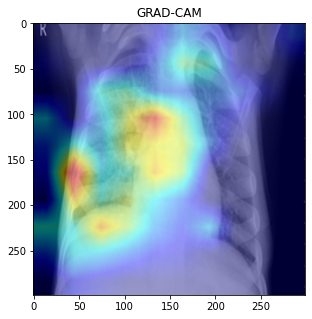

(299, 299, 3)


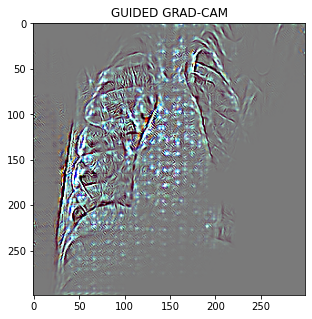

In [67]:
show_gradCAMs(model, gradCAM,guidedBP,"/content/Viral Pneumonia-131.png", n=1)